In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

In [30]:
df = pd.read_csv("eth_hourly_data.csv") 
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.dropna(subset=['time'])
df.sort_values('time', inplace=True)
df.reset_index(drop=True, inplace=True)

In [31]:
df['volume_rolling_5'] = df['volume'].rolling(5).mean()
df['tr'] = df[['high', 'low', 'close']].apply(lambda row: max(
    row['high'] - row['low'],
    abs(row['high'] - row['close']),
    abs(row['low'] - row['close'])
), axis=1)
df['atr_5'] = df['tr'].rolling(5).mean()
df['volatility_5'] = df['close'].rolling(5).std()
df['upper_shadow'] = (df['high'] - df[['open', 'close']].max(axis=1)) / df['open']
df['lower_shadow'] = (df[['open', 'close']].min(axis=1) - df['low']) / df['open']
df['volume_change'] = df['volume'].pct_change(1)

In [32]:
# --- Future Price Movement Classification Target ---
df['future_close'] = df['close'].shift(-1)  # Predicting 3 steps ahead
future_return = (df['future_close'] - df['close']) / df['close']
df['target'] = ((df['future_close'] - df['close']) / df['close']).apply(lambda x: 1 if x > 0 else 0)

# Drop rows with NaNs from rolling calculations
df.dropna(inplace=True)

In [33]:
features = ['volume_rolling_5', 'atr_5', 'volatility_5', 'upper_shadow', 'lower_shadow', 'volume_change']

In [34]:
threshold = 0.002  # 0.2% change, for example

df['future_close'] = df['close'].shift(-3)  # Predicting 3 steps ahead
delta = (df['future_close'] - df['close']) / df['close']
df['target'] = np.where(delta > threshold, 1, np.where(delta < -threshold, 2, 0))

In [35]:
X = df[features].values
y = df['target'].values

filtered_X = []
filtered_y = []

for i in range(len(X)):
    if not np.isnan(y[i]):
        filtered_X.append(X[i])
        filtered_y.append(y[i])

X = np.array(filtered_X)
y = np.array(filtered_y)

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
#y_labels = y + 1  # Convert -1/0/1 to 0/1/2 for class_weight and to_categorical
y_cat = to_categorical(y, num_classes=3)

In [36]:
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))
print(class_counts)

{0: 2096, 1: 4003, 2: 3811}


In [37]:
window = 10
X_seq, y_seq, y_seq_labels = [], [], []
for i in range(window, len(X_scaled)):
    X_seq.append(X_scaled[i - window:i])
    y_seq.append(y_cat[i])
    y_seq_labels.append(y[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
y_seq_labels = np.array(y_seq_labels)

# Train/test split
split = int(0.7 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
y_train_labels = y_seq_labels[:split]
y_test_labels = y_seq_labels[split:]

In [38]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True),
    LSTM(128, return_sequences=False),
    Dense(25),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         3,225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            78 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,007 (796.90 KB)

 Trainable params: 204,007 (796.90 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3885 - loss: 1.0783 - val_accuracy: 0.4226 - val_loss: 1.0303
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3970 - loss: 1.0718 - val_accuracy: 0.4508 - val_loss: 1.0278
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4016 - loss: 1.0664 - val_accuracy: 0.4219 - val_loss: 1.0338
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3962 - loss: 1.0665 - val_accuracy: 0.4283 - val_loss: 1.0417
Epoch 5/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4136 - loss: 1.0643 - val_accuracy: 0.4306 - val_loss: 1.0330
Epoch 6/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4159 - loss: 1.0584 - val_accuracy: 0.4441 - val_loss: 1.0377
Epoch 7/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4189 - loss: 1.0609 - val_accuracy: 0.4172 - val_loss: 1.0351
Epoch 8/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4290 - loss: 1.0514 - val_accu

In [42]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.3686868686868687
Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.21      0.19       496
           1       0.43      0.46      0.44      1263
           2       0.40      0.34      0.37      1211

    accuracy                           0.37      2970
   macro avg       0.33      0.34      0.33      2970
weighted avg       0.37      0.37      0.37      2970



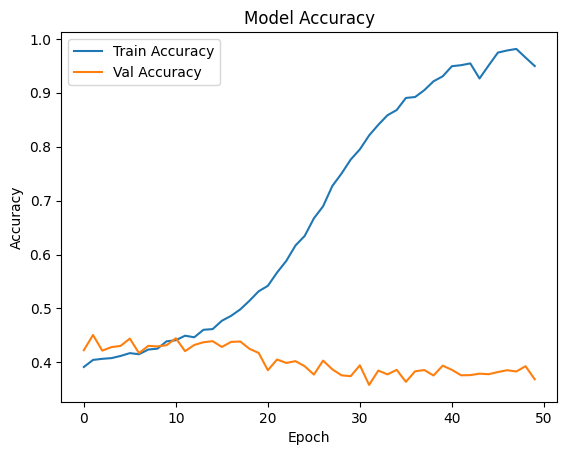

In [41]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()